In [1]:
import matplotlib.pyplot as plt
import datetime
import mxnet as mx
import mxnet.gluon as gluon
from mxnet import ndarray as nd
from mxnet.gluon import nn
from mxnet import autograd
from mxnet import init
from jupyterthemes import jtplot
jtplot.style(theme='onedork')

In [2]:
def transform(data, label):
    return data.astype('float32')/255, label.astype('float32')
mnist_train = gluon.data.vision.FashionMNIST(train=True, transform=transform)
mnist_test = gluon.data.vision.FashionMNIST(train=False, transform=transform)

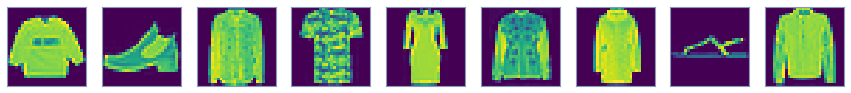

['pullover', 'ankle boot', 'shirt', 't-shirt', 'dress,', 'coat', 'coat', 'sandal', 'coat']


In [3]:
def show_images(images):
    n = images.shape[0]
    _, figs = plt.subplots(1, n, figsize=(15, 15))
    for i in range(n):
        figs[i].imshow(images[i].reshape((28, 28)).asnumpy())
        figs[i].axes.get_xaxis().set_visible(False)
        figs[i].axes.get_yaxis().set_visible(False)
    plt.show()

def get_text_labels(label):
    text_labels = [
        't-shirt', 'trouser', 'pullover', 'dress,', 'coat',
        'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot'
    ]
    return [text_labels[int(i)] for i in label]

data, label = mnist_train[0:9]
show_images(data)
print(get_text_labels(label))

In [4]:
ctx = mx.gpu(1)
batch_size = 256
train_data = gluon.data.DataLoader(mnist_train, batch_size, shuffle=True)
test_data = gluon.data.DataLoader(mnist_test, batch_size, shuffle=False)

In [5]:
def accuracy(output, label):
    return nd.mean(output.argmax(axis=1)==label).asscalar()


def evaluate_accuracy(data_iterator, net, ctx=ctx):
    acc, loss = 0.0, 0.0
    for data, label in data_iterator:
        label = label.as_in_context(ctx)
        acc += accuracy(net(data.as_in_context(ctx)), label)
        loss += nd.mean(softmax_cross_entropy(net(data.as_in_context(ctx)), label)).asscalar()
    return acc / len(data_iterator), loss / len(data_iterator)

# Fully connect dense neural network

In [6]:
net = nn.Sequential()

In [ ]:
with net.name_scope():
    net.add(gluon.nn.Flatten())
    net.add(gluon.nn.Dense(256, activation="relu"))
    net.add(gluon.nn.Dense(10))
net.initialize(ctx=ctx, init=init.Xavier())

In [ ]:
lr = 0.1
softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': lr})

train_loss_array = []
test_loss_array = []
train_acc_array = []
test_acc_array = []
for epoch in range(50):
    train_loss = 0.
    train_acc = 0.
    prev_time = datetime.datetime.now()
    for data, label in train_data:
        label = label.as_in_context(ctx)
        with autograd.record():
            output = net(data.as_in_context(ctx))
            loss = softmax_cross_entropy(output, label)
        loss.backward()
        trainer.step(batch_size)
        train_loss += nd.mean(loss).asscalar()
        train_acc += accuracy(output, label)
    test_acc, test_loss = evaluate_accuracy(test_data, net)
    cur_time = datetime.datetime.now()
    h, remainder = divmod((cur_time - prev_time).seconds, 3600)
    m, s = divmod(remainder, 60)
    time_str = "%02d:%02d:%02d" % (h, m, s)
    prev_time = cur_time
    train_loss_array.append(train_loss/len(train_data))
    train_acc_array.append(train_acc/len(train_data))
    test_loss_array.append(test_loss)
    test_acc_array.append(test_acc)
    print("Epoch %d. Train loss: %f, Train acc %.2f%%, Test loss %f, Test acc %.2f%%, Time %s, lr %s" % (
        epoch, train_loss/len(train_data), train_acc/len(train_data) * 100, test_loss, test_acc * 100, time_str, str(lr)))

Epoch 0. Train loss: 0.744318, Train acc 75.06%, Test loss 0.559075, Test acc 81.42%, Time 00:00:12, lr 0.1
Epoch 1. Train loss: 0.517755, Train acc 82.13%, Test loss 0.504297, Test acc 81.94%, Time 00:00:11, lr 0.1
Epoch 2. Train loss: 0.470942, Train acc 83.60%, Test loss 0.447262, Test acc 85.12%, Time 00:00:11, lr 0.1
Epoch 3. Train loss: 0.435122, Train acc 84.94%, Test loss 0.425152, Test acc 85.24%, Time 00:00:11, lr 0.1
Epoch 4. Train loss: 0.417606, Train acc 85.38%, Test loss 0.399240, Test acc 86.62%, Time 00:00:11, lr 0.1
Epoch 5. Train loss: 0.400548, Train acc 85.86%, Test loss 0.403465, Test acc 85.81%, Time 00:00:11, lr 0.1


In [ ]:
print(net)

In [ ]:
plt.figure(figsize=(16, 9))
plt.plot(train_loss_array, 'r-.',test_loss_array, 'b-.')
plt.legend(['train', 'valid'])
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [ ]:
plt.figure(figsize=(16, 9))
plt.plot(train_acc_array, 'r-.',test_acc_array, 'b-.')
plt.legend(['train', 'valid'])
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

# CNN

In [ ]:
cnn_net = nn.Sequential()

In [ ]:
with cnn_net.name_scope():
    cnn_net.add(nn.Conv2D(channels=20, kernel_size=3, padding=1, strides=1))
    cnn_net.add(nn.MaxPool2D(pool_size=2, strides=1, padding=1))
    cnn_net.add(nn.Conv2D(channels=50, kernel_size=3, padding=1, strides=1))
    cnn_net.add(nn.MaxPool2D(pool_size=2, strides=1, padding=1))
    cnn_net.add(nn.Flatten())
    cnn_net.add(nn.Dense(128, activation='relu'))
    cnn_net.add(nn.Dense(10))
    
cnn_net.initialize(ctx=ctx, init=init.Xavier())

In [ ]:
lr = 0.1
trainer = gluon.Trainer(cnn_net.collect_params(), 'sgd', {'learning_rate': lr, 'wd': 1e-5})

train_loss_array = []
test_loss_array = []
train_acc_array = []
test_acc_array = []
for epoch in range(50):
    train_loss = 0.0
    train_acc = 0.0
    prev_time = datetime.datetime.now()
    for data, label in train_data:
        label = label.as_in_context(ctx)
        with autograd.record():
            output = cnn_net(data.as_in_context(ctx))
            loss = softmax_cross_entropy(output, label)
        loss.backward()
        trainer.step(batch_size)
        train_loss += nd.mean(loss).asscalar()
        train_acc += accuracy(output, label)
    test_acc, test_loss = evaluate_accuracy(test_data, cnn_net)
    cur_time = datetime.datetime.now()
    h, remainder = divmod((cur_time - prev_time).seconds, 3600)
    m, s = divmod(remainder, 60)
    time_str = "%02d:%02d:%02d" % (h, m, s)
    prev_time = cur_time
    train_loss_array.append(train_loss/len(train_data))
    train_acc_array.append(train_acc/len(train_data))
    test_loss_array.append(test_loss)
    test_acc_array.append(test_acc)
    print("Epoch %d. Train loss: %f, Train acc %.2f%%, Test loss %f, Test acc %.2f%%, Time %s, lr %s" % (
        epoch, train_loss/len(train_data), train_acc/len(train_data) * 100, test_loss, test_acc * 100, time_str, str(lr)))

In [ ]:
plt.figure(figsize=(16, 9))
plt.plot(train_loss_array, 'r-.',test_loss_array, 'b-.')
plt.legend(['train', 'valid'])
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [ ]:
plt.figure(figsize=(16, 9))
plt.plot(train_acc_array, 'r-.',test_acc_array, 'b-.')
plt.legend(['train', 'valid'])
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()